# Lesson 05 Assignment - Hypothesis Simulation 

## Author - Dustin Burnham



## Instructions
Use the <a href="https://archive.ics.uci.edu/ml/datasets/Automobile">automotive data set</a> to perform the following:

1. Identify a likely distribution for price and several other features.
2. Compute basic summary statistics by both classical, bootstrap, and Bayesian methods
3. Compute confidence intervals for these summary statistics by classical, bootstrap, and Bayesian methods
4. Correctly use hypothesis tests to determine if the differences in pairs and multiple populations are significant:
            Classical tests
            Tukey’s Honest Significant Differences (HSD)
            Bootstrap methods
            Bayesian model

### Note
Please clearly outline the results with markdown text. Be sure your discussion includes narrative for your figures and tables so it is clear to the reader the importance of each bit of evidence.

In [1]:
fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Automobile%20price%20data%20_Raw_.csv"

In [2]:
# Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import scipy
import itertools
import scipy.stats as ss
from pandas.plotting import scatter_matrix
import statsmodels.api as sm
from sklearn.preprocessing import scale
import scipy.stats as stats

%matplotlib inline

### Clean the data

In [3]:
cars = pd.read_csv(fileName)

In [4]:
cars['price'] = pd.to_numeric(cars['price'], errors = 'coerce')
cars.loc[(cars['price'] == float('NaN')), 'price'] = np.nanmean(cars['price'])

In [5]:
cars['log_price'] = np.log(cars['price'])

## 1. Identify a likely distribution for price and several other features.

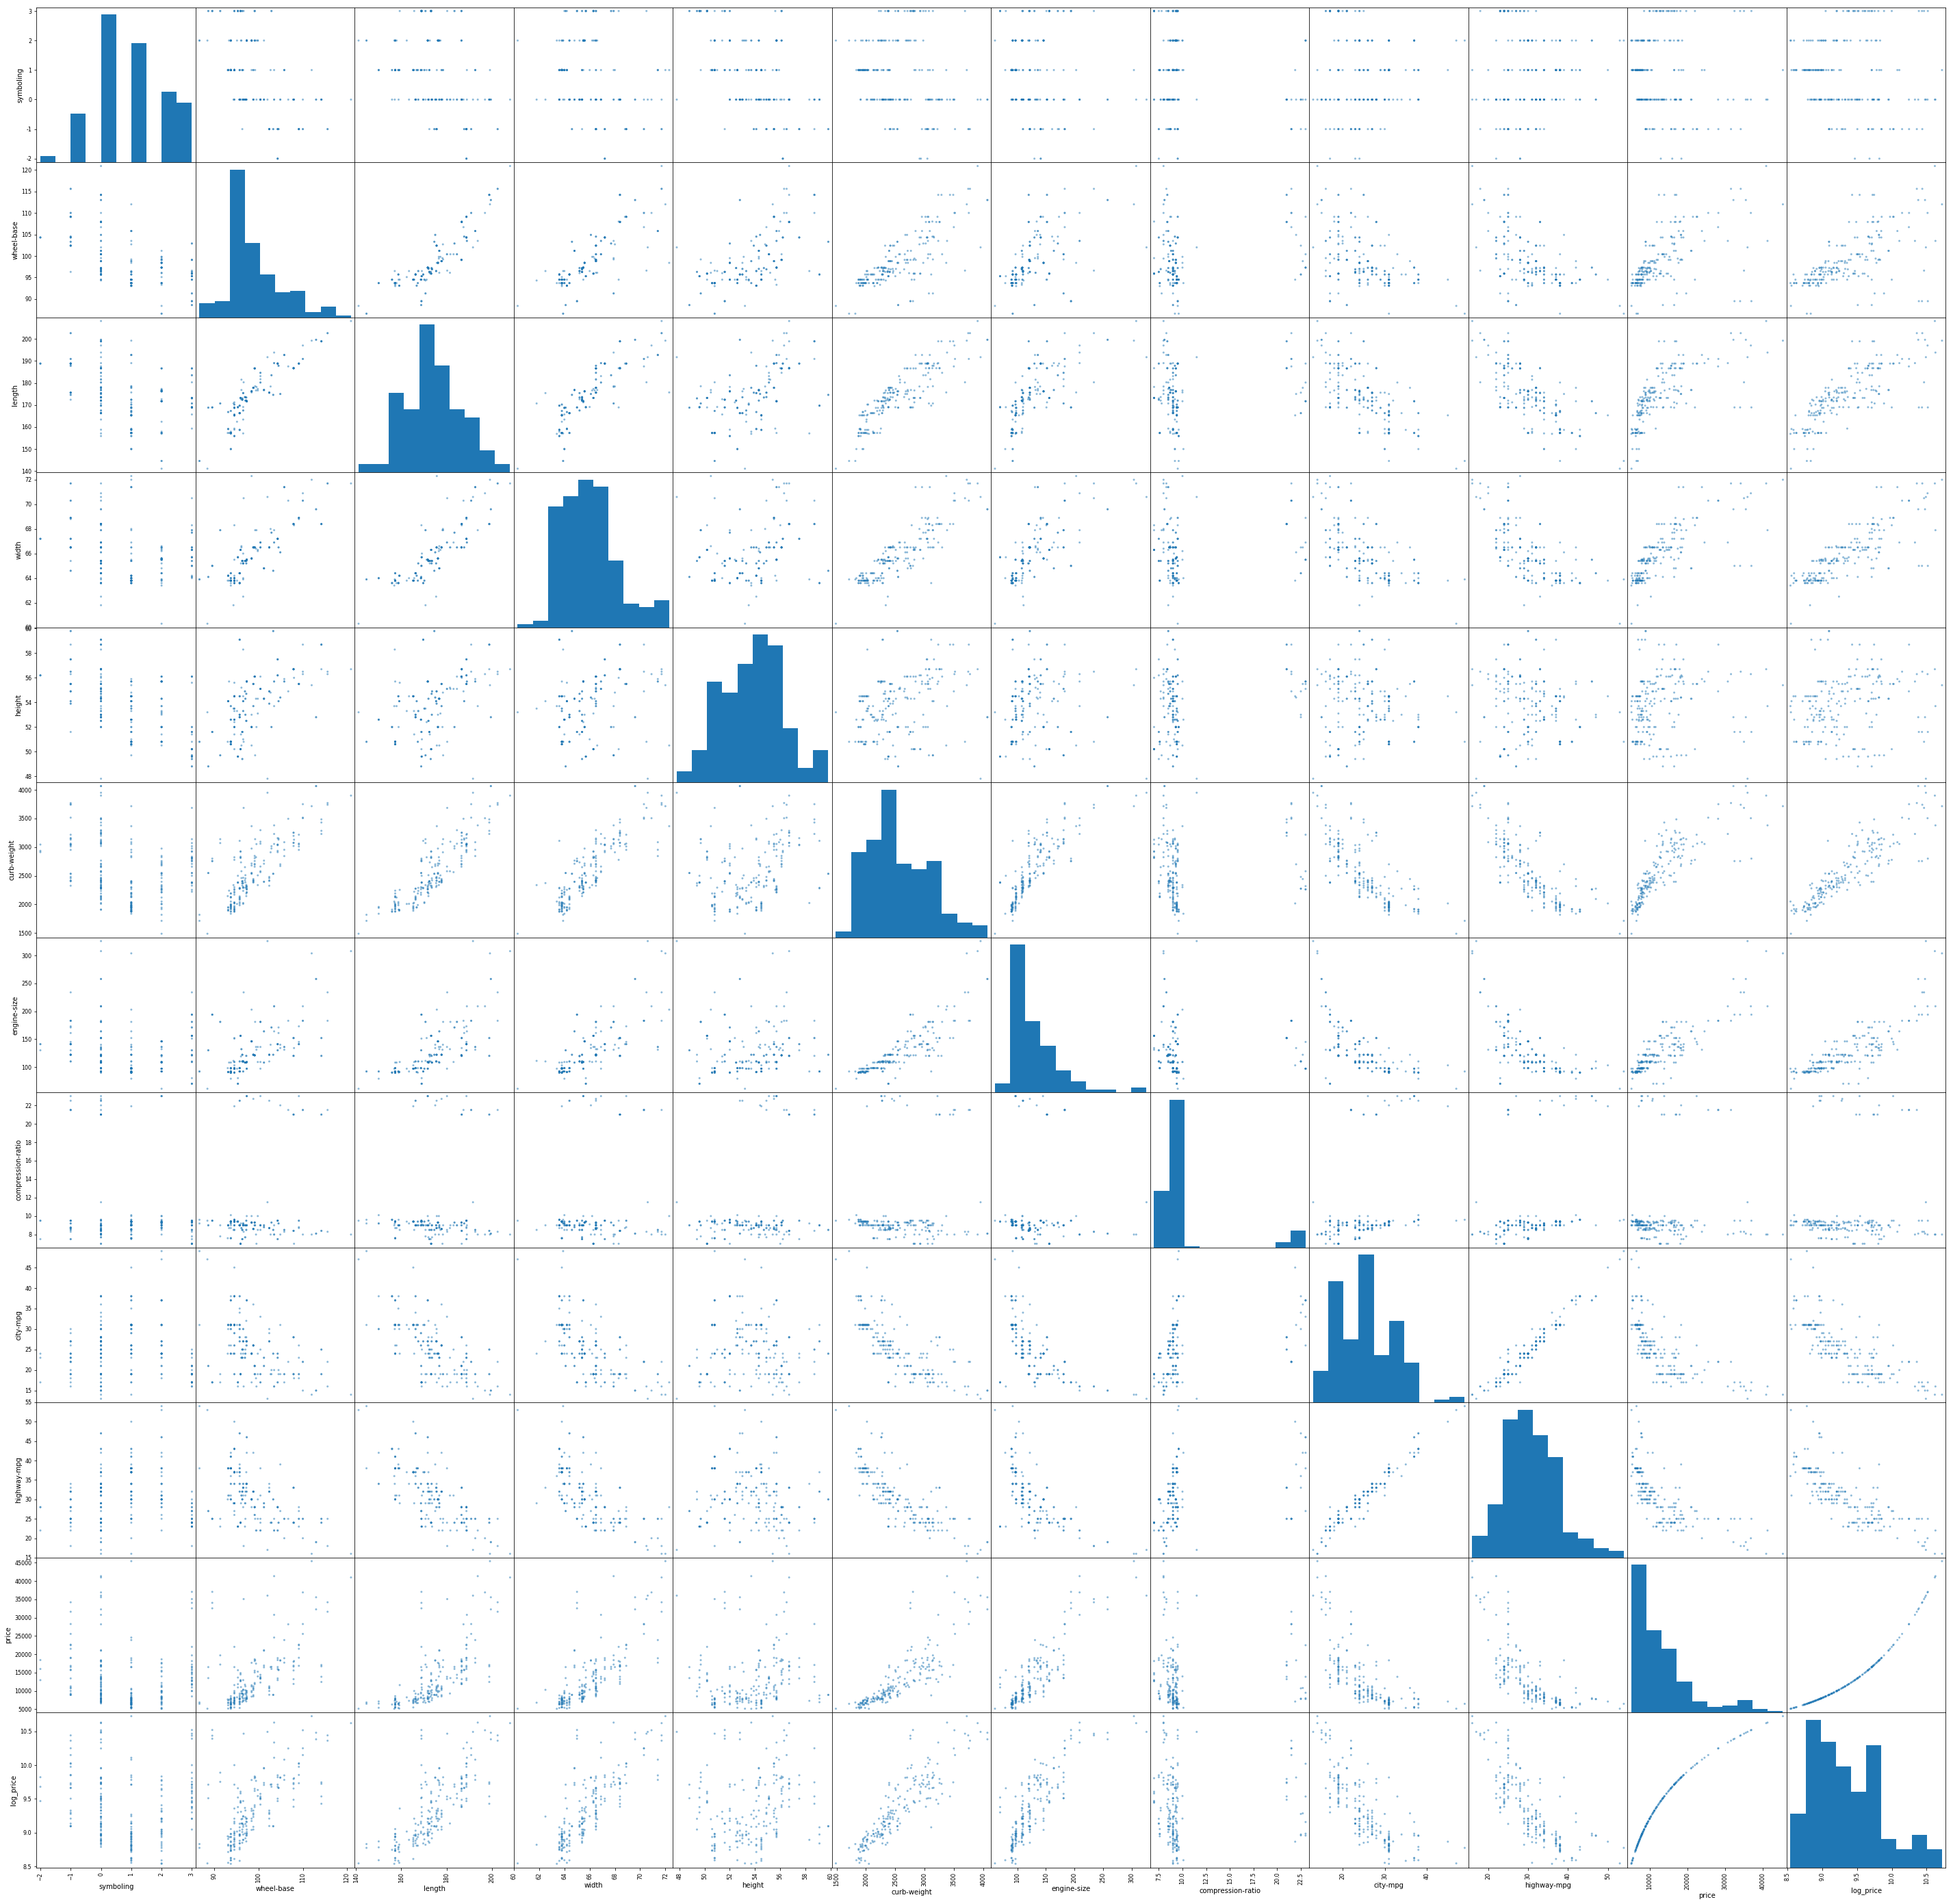

In [6]:
scatter_matrix(cars, figsize=(50, 50))
plt.show()

### Thoughts:
Looking at the diagonal histograms, I will target log-price, log engine size (look exponential) and the normal looking length, height, highway-mpg.  Before moving on I will use qq plots and ks testing for normality with an alpha of 0.05.

In [7]:
cars['log_price'] = np.log(cars['price'])
cars['log_engine_size'] = np.log(cars['engine-size'])

In [8]:
cars.loc[np.isnan(cars.log_price), 'log_price'] = np.nanmean(cars['log_price'])
cars.loc[np.isnan(cars.log_engine_size), 'log_engine_size'] = np.nanmean(cars['log_engine_size'])

In [9]:
columns = ['log_price', 'length', 'height', 'log_engine_size', 'highway-mpg']
cars_analysis = cars[columns]

In [10]:
cars_analysis.head()

,log_price,length,height,log_engine_size,highway-mpg
0,9.510075,168.8,48.8,4.867534,27
1,9.711116,168.8,48.8,4.867534,27
2,9.711116,171.2,52.4,5.023881,26
3,9.543235,176.6,54.3,4.691348,30
4,9.767095,176.6,54.3,4.912655,22


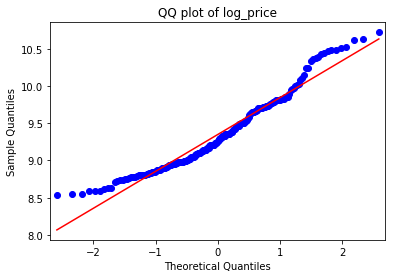

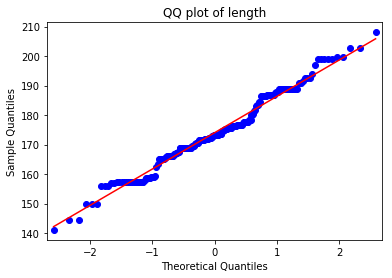

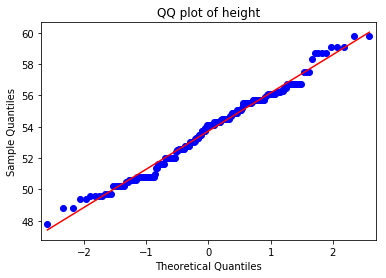

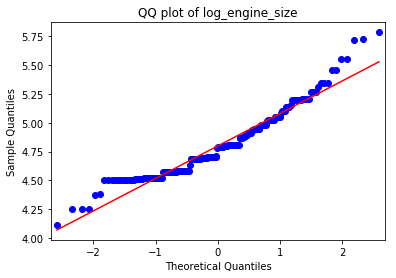

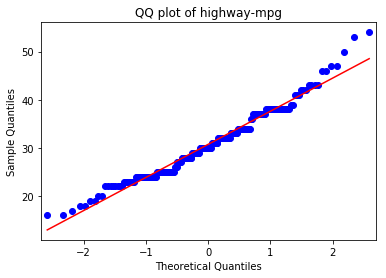

In [11]:
for col in columns:
    fig = sm.qqplot(cars[col], line = 's')
    plt.title('QQ plot of ' + col)
    plt.show()

In [12]:
def ks_test(dat, dist = 'norm'):
    from scipy.stats import kstest 
    ks_statisic, pvalue = kstest(dat, dist)
    print('KS-statistic = ' + str(ks_statisic))
    print('P-value = ' + str(pvalue))

In [13]:
for col in columns:
    print('The Kolmogorov-Smirnov Test for ' + col)
    temp = scale(cars_analysis[col])
    ks_test(temp)
    print('')

The Kolmogorov-Smirnov Test for log_price
KS-statistic = 0.09023646458780804
P-value = 0.06666759212923055

The Kolmogorov-Smirnov Test for length
KS-statistic = 0.0875915045816793
P-value = 0.0810290967651973

The Kolmogorov-Smirnov Test for height
KS-statistic = 0.07515927053593341
P-value = 0.18759456191908117

The Kolmogorov-Smirnov Test for log_engine_size
KS-statistic = 0.12872415638538293
P-value = 0.002020242966860238

The Kolmogorov-Smirnov Test for highway-mpg
KS-statistic = 0.09144155116147457
P-value = 0.06088044619447826



### Thoughts:
None of these distributions populations were convincingly normal except for the height feature.  However the only feature where we reject the null hypothesis that the distribution is normal is the log-engine size.  I will move forward with the rest.

## 2. Compute basic summary statistics by both classical, bootstrap, and Bayesian methods



### Classic mean and standard deviation

In [14]:
columns = ['log_price', 'length', 'height', 'highway-mpg']
means_dict = {}
std_dict = {}
for col in columns:
    means_dict[col] = cars[col].mean()
    std_dict[col] = cars[col].std()

In [15]:
def plot_hist(x, p=5):
    # Plot the distribution and mark the mean
    plt.hist(x, alpha=.5)
    plt.axvline(x.mean())
    # 95% confidence interval    
    plt.axvline(np.percentile(x, p/2.), color='red', linewidth=3)
    plt.axvline(np.percentile(x, 100-p/2.), color='red', linewidth=3)

def plot_dists(a, nbins, stat, a_label='pop-a', p=5):
    # Create a single sequence of bins to be shared across both
    # distribution plots for visualization consistency.
    breaks = np.linspace(
        a.min(), 
        a.max(), 
        num=nbins+1)

    plt.subplot(2, 1, 1)
    plot_hist(a)
    plt.title(a_label)
    plt.xlabel(stat)
    plt.ylabel('Count')

### Bootstrap mean and standard deviation

In [16]:
def bootstrap_mean(df, col_name, n_replicas):
    boot_mean = pd.Series([df[col_name].sample(frac=1, replace = True).mean() for i in range(n_replicas)])
    #plot_dists(boot_mean, nbins=80, a_label=col_name, stat='mean')
    #plt.show()
    return(boot_mean)

def bootstrap_std(df, col_name, n_replicas):
    boot_std = pd.Series([df[col_name].sample(frac=1, replace = True).std() for i in range(n_replicas)])
    return(boot_std)

In [17]:
n = 10000
boot_dict_means = {}

for col in columns:
    boot_dict_means[col] = bootstrap_mean(cars, col, n)

In [18]:
boot_dict_std = {}
for col in columns:
    boot_dict_std[col] = bootstrap_std(cars, col, n)

### Bayesian mean and standard deviation

In [19]:
# Prior calculation.  Assume uniform with height of classic mean/std
prior_dict = {}
prior_std_dict = {}
for col in columns:
    mu = means_dict[col]
    sigma = std_dict[col]
    prior_dict[col] = mu
    prior_std_dict[col] = sigma

In [20]:
def likelihood(mu, sigma, data):
    l = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (data - mu)**2 / (2 * sigma**2))
    return(l/sum(l))                                            

In [21]:
# Calculate likelihood function
likelihood_std_dict = {}
x_std_dict = {}
for col in columns:
    mu = boot_dict_std[col].mean()
    sigma = boot_dict_std[col].std()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    x_std_dict[col] = x
    l = likelihood(mu, sigma, x)
    likelihood_std_dict[col] = l

In [22]:
likelihood_dict = {}
x_dict = {}
for col in columns:
    mu = boot_dict_means[col].mean()
    sigma = boot_dict_means[col].std()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    x_dict[col] = x
    l = likelihood(mu, sigma, x)
    likelihood_dict[col] = l
    #plt.plot(x, l)
    #plt.title('Likelihood function for ' + col)
    #plt.xlabel('Mean')
    #plt.ylabel('Likelihood')
    #plt.show()

In [23]:
# Calculate the normalized posterior
def posterior(prior, like):
    post = prior * like # compute the product of the probabilities
    return post / sum(post) # normalize the distribution to sum to unity

In [24]:
post_means_dict = {}
post_means_dict_dat = {}

for col in columns:
    post = posterior(likelihood_dict[col], prior_dict[col])
    x = x_dict[col]
    # Find x value with where posterior maximized
    post_means_dict[col] = x[np.where(post == max(post))[0][0]]
    # Save posterior
    post_means_dict_dat[col] = post
    
post_std_dict = {}
post_std_dict_dat = {}
for col in columns:
    post = posterior(likelihood_std_dict[col], prior_std_dict[col])
    x = x_std_dict[col]
    # Find x value with where posterior maximized
    post_std_dict[col] = x[np.where(post == max(post))[0][0]]
    # Save posterior
    post_std_dict_dat[col] = post

In [25]:
# Find means,std of boot samples
boot_means = {}
boot_std = {}
for col in columns:
    boot_means[col] = np.mean(boot_dict_means[col])
    boot_std[col] = np.mean(boot_dict_std[col])

In [26]:
means_dict

{'log_price': 9.350114658353988,
 'length': 174.04926829268305,
 'height': 53.724878048780525,
 'highway-mpg': 30.75121951219512}

In [27]:
# Make table for comparison
total_means = {'classical':list(means_dict.values()),
              'bootstrap':list(boot_means.values()),
              'bayesian':list(post_means_dict.values())}
means_df = pd.DataFrame(data=total_means)
means_df.rename(index={0:'log_price',1:'length', 2:'height', 3:'highway-mpg'}, inplace=True)

In [28]:
means_df

,classical,bootstrap,bayesian
log_price,9.350115,9.349891,9.348844
length,174.049268,174.052786,174.026898
height,53.724878,53.723689,53.718493
highway-mpg,30.751220,30.756056,30.741354


In [29]:
total_std = {'classical':list(std_dict.values()),
              'bootstrap':list(boot_std.values()),
              'bayesian':list(post_std_dict.values())}
std_df = pd.DataFrame(data=total_std)
std_df.rename(index={0:'log_price',1:'length', 2:'height', 3:'highway-mpg'}, inplace=True)

In [30]:
std_df

,classical,bootstrap,bayesian
log_price,0.497303,0.495587,0.494870
length,12.337289,12.297791,12.279934
height,2.443522,2.436715,2.433514
highway-mpg,6.886443,6.855621,6.844363


### Thoughts:
All three approaches achieve a similar estimate for population statistic mean and standard deviation.  This is is expected.  I would assum that bootstrapped and bayesian statistics are more accurate given they rely on either a large amount of samples or modeling.

## 3. Compute confidence intervals for these summary statistics by classical, bootstrap, and Bayesian methods



In [31]:
# CI for classic mean
classic_ci_means_dict = {}
a = 0.05

for col in columns:
    classic_ci_means_dict[col] = (np.percentile(cars[col], a/2),np.percentile(cars[col], 100-a/2))

In [32]:
# CI for bootsrapped mean and std
bootstrap_ci_means_dict = {}
bootstrap_ci_std_dict = {}

for col in columns:
    bootstrap_ci_means_dict[col] = (np.percentile(boot_dict_means[col], a/2), np.percentile(boot_dict_means[col], 100-a/2))
    bootstrap_ci_std_dict[col] = (np.percentile(boot_dict_std[col], a/2),np.percentile(boot_dict_std[col], 100-a/2))

In [33]:
# Bayesian mean and std CI
post_ci_means_dict = {}
post_ci_std_dict = {}

for col in columns:
    post_ci_means_dict[col] = (np.percentile(x_dict[col], a/2), np.percentile(x_dict[col], 100-a/2))
    post_ci_std_dict[col] = (np.percentile(x_dict[col], a/2), np.percentile(x_dict[col], 100-a/2))

In [34]:
# Table for comparison
means_df['classic_CI'] = list(classic_ci_means_dict.values())
means_df['bootstrap_CI'] = list(bootstrap_ci_means_dict.values())
means_df['bayes_CI'] = list(post_ci_means_dict.values())
means_df

,classical,bootstrap,bayesian,classic_CI,bootstrap_CI,bayes_CI
log_price,9.350115,9.349891,9.348844,"(8.540846800494872, 10.718458773809836)","(9.236820472672633, 9.480635619916153)","(9.246270817462314, 9.453510979064134)"
length,174.049268,174.052786,174.026898,"(141.27849999999998, 207.81949999999992)","(171.2546229268293, 176.95683158536582)","(171.49120056532124, 176.61437045906766)"
height,53.724878,53.723689,53.718493,"(47.85099999999999, 59.8)","(53.14097512195126, 54.33732256097563)","(53.209466287149425, 54.23791254211907)"
highway-mpg,30.751220,30.756056,30.741354,"(16.0, 53.948999999999984)","(29.058536585365854, 32.529274390243884)","(29.301339787129, 32.210771432383055)"


In [35]:
std_df['bootstrap_CI'] = list(bootstrap_ci_std_dict.values())
std_df['bayes_CI'] = list(post_ci_std_dict.values())
std_df

,classical,bootstrap,bayesian,bootstrap_CI,bayes_CI
log_price,0.497303,0.495335,0.494618,"(0.41329629934869966, 0.5813685580567706)","(9.24576408609334, 9.453963463886852)"
length,12.337289,12.300387,12.282280,"(10.34604110275767, 14.37039707781863)","(171.45738854143931, 176.63906023904988)"
height,2.443522,2.436796,2.433595,"(2.0576676522230937, 2.7824183490763597)","(53.21354716624919, 54.24394824838502)"
highway-mpg,6.886443,6.855955,6.844734,"(5.629082474355774, 8.19907166627019)","(29.297782413085848, 32.198623440572455)"


### Plotting classic mean CI

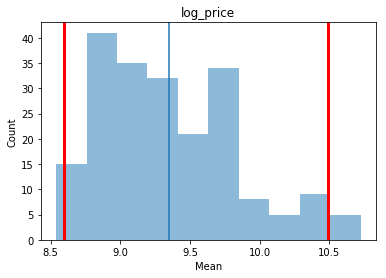

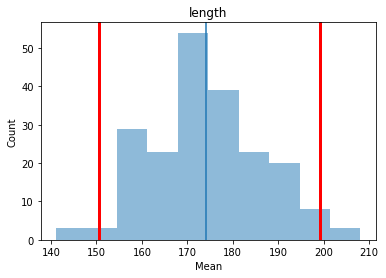

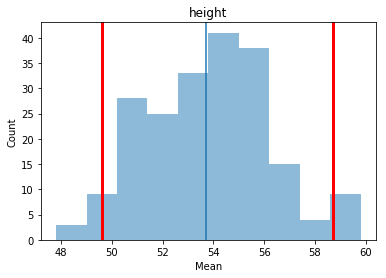

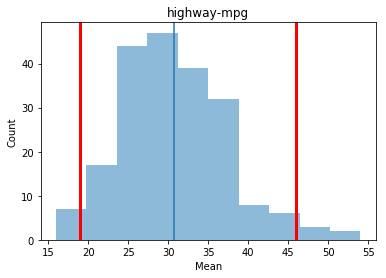

In [36]:
for col in columns:
    plot_hist(cars[col])
    plt.xlabel("Mean")
    plt.ylabel("Count")
    plt.title(col)
    plt.show()

### Plotting bootstrapped CI

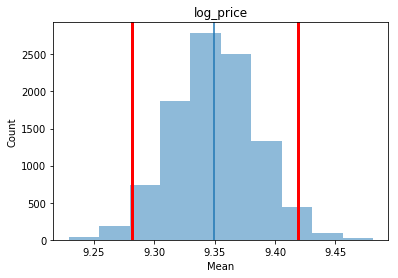

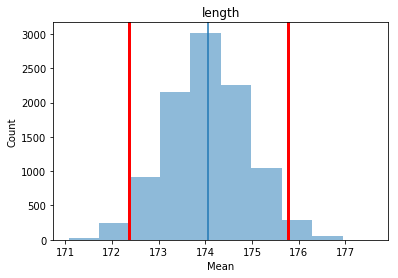

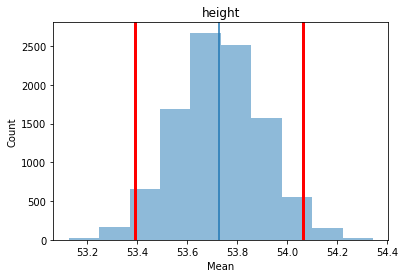

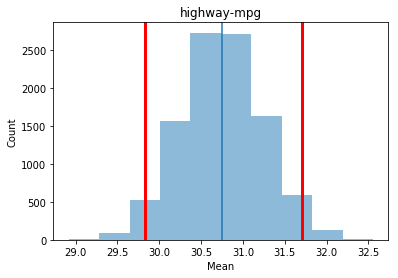

In [37]:
for col in columns:
    plot_hist(boot_dict_means[col])
    plt.xlabel("Mean")
    plt.ylabel("Count")
    plt.title(col)
    plt.show()

## Interpretation:
When looking at the CI for population mean vs. the bootsrapped estimate we notice two things.  The CI for the bootstrapped and bayesian CI are much more precise (narrower) than the classic estimate.  In addition, when looking at the plots, the distributions are much more normally distributed.

## 4. Correctly use hypothesis tests to determine if the differences in pairs and multiple populations are significant:
            Classical tests
            Tukey’s Honest Significant Differences (HSD)
            Bootstrap methods
            Bayesian model

Check the difference between log-price in two-doored cars vs four-doored cars and standard vs turbo aspiration.

Null hypothesis: The difference between the price in the two groups is zero.

Alternative: There is a difference between the price of the two populations.

alpha = 0.05

In [38]:
two_doors_price = cars.loc[cars['num-of-doors'] == 'two','log_price']
four_doors_price = cars.loc[cars['num-of-doors'] == 'four','log_price']

In [39]:
def bootstrap_mean(col1, col2, n_replicas):
    col1_mean = pd.Series([col1.sample(n=50, replace = True).mean() for i in range(n_replicas)])
    col2_mean = pd.Series([col2.sample(n=50, replace = True).mean() for i in range(n_replicas)])
    return(col1_mean - col2_mean)

In [40]:
diff = bootstrap_mean(two_doors_price, four_doors_price, 10000)

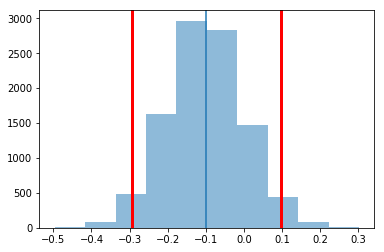

In [41]:
plot_hist(diff)

In [42]:
z = (np.mean(diff) - 0)/np.std(diff)

In [43]:
p_value = stats.norm.sf(abs(z))*2 #twosided

In [44]:
p_value

0.31401289213158334

In addition to the null hypothesis falling within our CI, the p-value for this prediction is not near the 0.025 (two sided) threshold.  We fail to reject the null hypothesis that there is no difference in price between 2 and 4 door cars.

In [45]:
std_price = cars.loc[cars['aspiration'] == 'std','log_price']
turbo_price = cars.loc[cars['aspiration'] == 'turbo','log_price']

In [46]:
diff = bootstrap_mean(std_price, turbo_price, 10000)

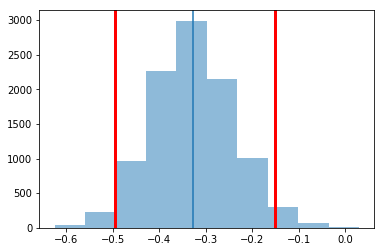

In [47]:
plot_hist(diff)

In [48]:
z = (np.mean(diff) - 0)/np.std(diff)

In [49]:
p_value = stats.norm.sf(abs(z))*2 #twosided

In [50]:
p_value

0.00019398359032924805

The CI doesn't contain the null hypothesis value of 0.0 and the p-value is sufficiently small enought to reject the null hypothesis  that there is no difference in price between standard and turbo cars.